## 1. Setup and Load Data

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sentence_transformers import SentenceTransformer
import torch
from sklearn.metrics.pairwise import cosine_similarity

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

DATA_DIR = Path('data_new')
MODELS_DIR = Path('models')

# Load data
df = pd.read_csv(DATA_DIR / 'SNow_incident_ticket_data.csv')
print(f"Loaded {len(df)} incidents")

Device: cpu
Loaded 10633 incidents


In [2]:
# Recreate combined text (same logic as evaluate_model.ipynb)
def create_combined_text(row):
    text_parts = []
    for col in ['Number', 'Description', 'User input', 'Resolution notes']:
        if col in row.index:
            value = str(row.get(col, '')).strip() if pd.notna(row.get(col)) else ''
            if value and value.lower() != 'nan':
                text_parts.append(value)
    return ' '.join(text_parts) if text_parts else ''

df['combined_text'] = df.apply(create_combined_text, axis=1)
df['combined_text'] = df['combined_text'].astype(str)
df = df[df['combined_text'].str.len() > 10].reset_index(drop=True)

print(f"After filtering: {len(df)} valid incidents")
print(f"\nData columns: {df.columns.tolist()}")
print(f"Has 'Category' column: {'Category' in df.columns}")

After filtering: 10633 valid incidents

Data columns: ['Number', 'Description', 'Opened by', 'Company', 'ITSM Department', 'Created', 'Urgency', 'Impact', 'Priority', 'Assignment group', 'Assigned to', 'State', 'Service', 'Service offering', 'Closed', 'Closed by', 'Category', 'Subcategory', 'Resolution code', 'Resolution notes', 'User input', 'Comments and Work notes', 'Manday Effort (hrs)', 'Ticket Type', 'AMS Domain', 'AMS System Type', 'AMS Category Type', 'AMS Service Type', 'AMS Business Related', 'AMS IT Related', 'combined_text']
Has 'Category' column: True


## 2. Generate Test Pairs (Same as evaluate_model.ipynb)

In [3]:
from typing import List, Tuple
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity as sklearn_cosine_similarity

def generate_test_pairs(df: pd.DataFrame, 
                       num_positives: int = 500,
                       num_easy_negatives: int = 500,
                       num_hard_negatives: int = 500,
                       random_state: int = 42) -> Tuple[List[str], List[str], List[int]]:
    
    np.random.seed(random_state)
    texts1, texts2, labels = [], [], []
    has_categories = 'Category' in df.columns
    
    if has_categories:
        print("Using category-based pair generation")
        categories = df['Category'].dropna().unique()
        print(f"Found {len(categories)} categories")
        
        # Positive pairs - same category
        for _ in range(num_positives):
            cat = np.random.choice(categories)
            cat_incidents = df[df['Category'] == cat]
            if len(cat_incidents) >= 2:
                idx1, idx2 = np.random.choice(cat_incidents.index, size=2, replace=False)
                texts1.append(df.loc[idx1, 'combined_text'])
                texts2.append(df.loc[idx2, 'combined_text'])
                labels.append(1)
        
        # Easy negatives - different categories
        for _ in range(num_easy_negatives):
            cat1, cat2 = np.random.choice(categories, size=2, replace=False)
            incidents1 = df[df['Category'] == cat1]
            incidents2 = df[df['Category'] == cat2]
            if len(incidents1) > 0 and len(incidents2) > 0:
                idx1 = np.random.choice(incidents1.index)
                idx2 = np.random.choice(incidents2.index)
                texts1.append(df.loc[idx1, 'combined_text'])
                texts2.append(df.loc[idx2, 'combined_text'])
                labels.append(0)
    else:
        print("No category column found - using random pair generation")
        for _ in range(num_positives):
            idx1, idx2 = np.random.choice(len(df), size=2, replace=False)
            texts1.append(df.loc[idx1, 'combined_text'])
            texts2.append(df.loc[idx2, 'combined_text'])
            labels.append(1)
        for _ in range(num_easy_negatives):
            idx1, idx2 = np.random.choice(len(df), size=2, replace=False)
            texts1.append(df.loc[idx1, 'combined_text'])
            texts2.append(df.loc[idx2, 'combined_text'])
            labels.append(0)
    
    # Hard negatives
    print("\nGenerating hard negatives with TF-IDF...")
    sample_size = min(2000, len(df))
    sample_df = df.sample(n=sample_size, random_state=random_state)
    
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(sample_df['combined_text'])
    
    hard_neg_count = 0
    attempts = 0
    max_attempts = num_hard_negatives * 10
    
    while hard_neg_count < num_hard_negatives and attempts < max_attempts:
        idx1 = np.random.randint(0, len(sample_df))
        similarities = sklearn_cosine_similarity(tfidf_matrix[idx1:idx1+1], tfidf_matrix).flatten()
        hard_neg_candidates = np.where((similarities > 0.3) & (similarities < 0.6))[0]
        hard_neg_candidates = hard_neg_candidates[hard_neg_candidates != idx1]
        
        if len(hard_neg_candidates) > 0:
            idx2 = np.random.choice(hard_neg_candidates)
            if has_categories:
                cat1 = sample_df.iloc[idx1].get('Category')
                cat2 = sample_df.iloc[idx2].get('Category')
                if cat1 == cat2:
                    attempts += 1
                    continue
            
            texts1.append(sample_df.iloc[idx1]['combined_text'])
            texts2.append(sample_df.iloc[idx2]['combined_text'])
            labels.append(0)
            hard_neg_count += 1
        
        attempts += 1
    
    print(f"Generated {hard_neg_count} hard negatives ({attempts} attempts)")
    print(f"\nTotal test pairs: {len(labels)}")
    print(f"  Positive pairs: {sum(labels)}")
    print(f"  Negative pairs: {len(labels) - sum(labels)}")
    
    return texts1, texts2, labels

# Generate pairs
test_texts1, test_texts2, test_labels = generate_test_pairs(df, random_state=42)
test_labels = np.array(test_labels)

Using category-based pair generation
Found 4 categories

Generating hard negatives with TF-IDF...
Generated 500 hard negatives (2975 attempts)

Total test pairs: 1500
  Positive pairs: 500
  Negative pairs: 1000


## 3. Inspect Test Pair Quality

In [4]:
# Show examples of positive pairs
print("="*80)
print("POSITIVE PAIR EXAMPLES (Label=1 - Should be similar)")
print("="*80)

pos_indices = np.where(test_labels == 1)[0]
for i in range(min(3, len(pos_indices))):
    idx = pos_indices[i]
    print(f"\n--- Positive Pair {i+1} ---")
    print(f"Text 1 ({len(test_texts1[idx])} chars):")
    print(test_texts1[idx][:200] + "..." if len(test_texts1[idx]) > 200 else test_texts1[idx])
    print(f"\nText 2 ({len(test_texts2[idx])} chars):")
    print(test_texts2[idx][:200] + "..." if len(test_texts2[idx]) > 200 else test_texts2[idx])

POSITIVE PAIR EXAMPLES (Label=1 - Should be similar)

--- Positive Pair 1 ---
Text 1 (177 chars):
INC0020661 Please help to check error when we do CO44 processing for plant RIFW. 
See the issue in attachment file User has not run KKs2 before co44 that is the reason of error

Text 2 (359 chars):
INC0038333 eCU-M1-24000164, request to reduce credit limit from 60k to 55k but in SAP still showing as 60K.
As advised by ServiceNow team, SAP team will assist to investigate. Credit limit is updated...

--- Positive Pair 2 ---
Text 1 (420 chars):
INC0048617 unable to approve eSO refer attached screenshot Hi Abu san,
Good evening!

As discussed in teams, the eSO document approval was working as expected from your laptop and local IT team is ...

Text 2 (426 chars):
INC0013719 Kindly Please help to install ZEBRA Printer on our SAP system for the purpose of "printing part labels"
With details as follows :
Data Printer From (IN) AX : 
PGI – Barcode Printer ZDesi...

--- Positive Pair 3 ---
Text 1 (

In [5]:
# Show examples of negative pairs
print("\n" + "="*80)
print("NEGATIVE PAIR EXAMPLES (Label=0 - Should be different)")
print("="*80)

neg_indices = np.where(test_labels == 0)[0]
for i in range(min(3, len(neg_indices))):
    idx = neg_indices[i]
    print(f"\n--- Negative Pair {i+1} ---")
    print(f"Text 1 ({len(test_texts1[idx])} chars):")
    print(test_texts1[idx][:200] + "..." if len(test_texts1[idx]) > 200 else test_texts1[idx])
    print(f"\nText 2 ({len(test_texts2[idx])} chars):")
    print(test_texts2[idx][:200] + "..." if len(test_texts2[idx]) > 200 else test_texts2[idx])


NEGATIVE PAIR EXAMPLES (Label=0 - Should be different)

--- Negative Pair 1 ---
Text 1 (377 chars):
INC0047074 we have an issue with account Z00000-999.
when we check it come from two production order (106842798 and 106842799). 
please help to check, why this transaction enter to account "Z" inste...

Text 2 (904 chars):
INC0068269 Dear Team

Error occurred while processing the EDI transaction. Please find the details below and attached is the file associated to the transaction.

Interface       FUTURE Invoice
Subsidi...

--- Negative Pair 2 ---
Text 1 (495 chars):
INC0058517 UAT document “PSP0211” facing posting error due to cross division posting related to new profitcenter implementation in PSP system. Hence, need to discuss with SAP team related to SAP confi...

Text 2 (238 chars):
INC0033260 Dear MM support team,
Please help to check the PO 4507602024 in TGP, we can't print it by tcode ZSGMM_0006, ZSGMM_0007.
More details as attached pictures.
Thank you for your support RITM...



## 4. Calculate Baseline Model Embeddings

In [4]:
# Load baseline model
print("Loading baseline model...")
baseline_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2', device=device)

# Encode test pairs
print("Encoding text pairs...")
embeddings1_baseline = baseline_model.encode(test_texts1, batch_size=64, show_progress_bar=True, convert_to_numpy=True)
embeddings2_baseline = baseline_model.encode(test_texts2, batch_size=64, show_progress_bar=True, convert_to_numpy=True)

# Compute similarity scores
baseline_scores = np.sum(embeddings1_baseline * embeddings2_baseline, axis=1) / (
    np.linalg.norm(embeddings1_baseline, axis=1) * np.linalg.norm(embeddings2_baseline, axis=1)
)

print(f"\nBaseline scores: min={baseline_scores.min():.4f}, max={baseline_scores.max():.4f}, mean={baseline_scores.mean():.4f}")

Loading baseline model...
Encoding text pairs...


Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Batches:   0%|          | 0/24 [00:00<?, ?it/s]


Baseline scores: min=0.0745, max=0.9979, mean=0.5163


## 5. Analyze Score Distributions

In [5]:
# Separate by label
pos_scores_baseline = baseline_scores[test_labels == 1]
neg_scores_baseline = baseline_scores[test_labels == 0]

print("="*80)
print("BASELINE MODEL SCORE DISTRIBUTION")
print("="*80)
print(f"\nPositive pairs (label=1):")
print(f"  Mean: {pos_scores_baseline.mean():.4f}")
print(f"  Median: {np.median(pos_scores_baseline):.4f}")
print(f"  Std: {pos_scores_baseline.std():.4f}")
print(f"  Min-Max: [{pos_scores_baseline.min():.4f}, {pos_scores_baseline.max():.4f}]")

print(f"\nNegative pairs (label=0):")
print(f"  Mean: {neg_scores_baseline.mean():.4f}")
print(f"  Median: {np.median(neg_scores_baseline):.4f}")
print(f"  Std: {neg_scores_baseline.std():.4f}")
print(f"  Min-Max: [{neg_scores_baseline.min():.4f}, {neg_scores_baseline.max():.4f}]")

# Overlap analysis
overlap = np.sum((pos_scores_baseline < neg_scores_baseline.max()) & (pos_scores_baseline > neg_scores_baseline.min())) / len(pos_scores_baseline)
print(f"\nScore overlap (% of positives within negative score range): {overlap*100:.1f}%")

BASELINE MODEL SCORE DISTRIBUTION

Positive pairs (label=1):
  Mean: 0.4878
  Median: 0.4341
  Std: 0.2162
  Min-Max: [0.0990, 0.9979]

Negative pairs (label=0):
  Mean: 0.5305
  Median: 0.5152
  Std: 0.1883
  Min-Max: [0.0745, 0.9645]

Score overlap (% of positives within negative score range): 96.8%


C:\Users\donov\AppData\Local\Temp\ipykernel_32868\1525743141.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Negative (0)', 'Positive (1)'], patch_artist=True)


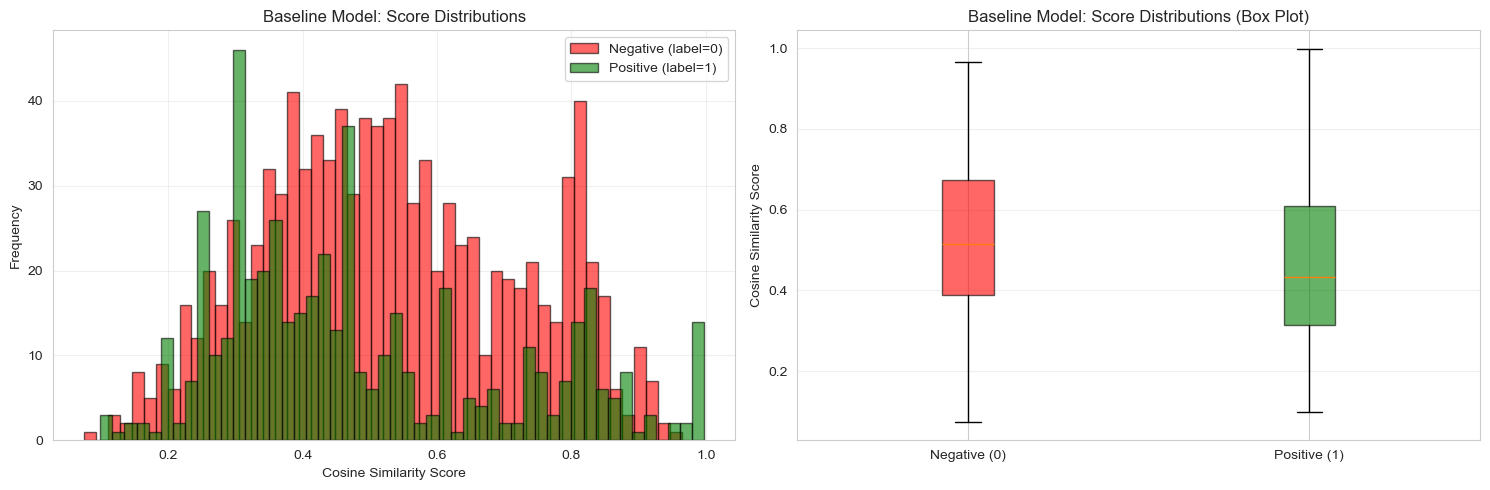


Separability: Mean positive (0.4878) vs Mean negative (0.5305)
Difference: -0.0427


In [8]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histograms
ax = axes[0]
ax.hist(neg_scores_baseline, bins=50, alpha=0.6, label='Negative (label=0)', color='red', edgecolor='black')
ax.hist(pos_scores_baseline, bins=50, alpha=0.6, label='Positive (label=1)', color='green', edgecolor='black')
ax.set_xlabel('Cosine Similarity Score')
ax.set_ylabel('Frequency')
ax.set_title('Baseline Model: Score Distributions')
ax.legend()
ax.grid(True, alpha=0.3)

# Box plots
ax = axes[1]
data_to_plot = [neg_scores_baseline, pos_scores_baseline]
bp = ax.boxplot(data_to_plot, labels=['Negative (0)', 'Positive (1)'], patch_artist=True)
bp['boxes'][0].set_facecolor('red')
bp['boxes'][0].set_alpha(0.6)
bp['boxes'][1].set_facecolor('green')
bp['boxes'][1].set_alpha(0.6)
ax.set_ylabel('Cosine Similarity Score')
ax.set_title('Baseline Model: Score Distributions (Box Plot)')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nSeparability: Mean positive ({pos_scores_baseline.mean():.4f}) vs Mean negative ({neg_scores_baseline.mean():.4f})")
print(f"Difference: {pos_scores_baseline.mean() - neg_scores_baseline.mean():.4f}")

## 6. Analyze Hard Negatives - Are They Actually Hard?

In [8]:
# Identify which negatives are "hard" (high TF-IDF similarity)
# We'll use a separate baseline encoding to compute similarity

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform([t for t in test_texts1 + test_texts2])

# For simplicity, estimate which negatives are hard by checking text similarity
print("Analyzing negative pairs for semantic overlap...\n")

neg_indices = np.where(test_labels == 0)[0]
neg_example_similarities = []

for idx in neg_indices[:100]:  # Sample first 100 negatives
    # Simple word overlap ratio
    words1 = set(test_texts1[idx].lower().split())
    words2 = set(test_texts2[idx].lower().split())
    overlap = len(words1 & words2) / (len(words1 | words2) + 1e-10)
    neg_example_similarities.append(overlap)

print(f"Negative pair word overlap (sample of 100):")
print(f"  Mean: {np.mean(neg_example_similarities):.4f}")
print(f"  Median: {np.median(neg_example_similarities):.4f}")
print(f"  Max: {np.max(neg_example_similarities):.4f}")
print(f"\nThis tells us if 'different category' pairs actually share significant vocabulary...")

Analyzing negative pairs for semantic overlap...

Negative pair word overlap (sample of 100):
  Mean: 0.0893
  Median: 0.0667
  Max: 0.5301

This tells us if 'different category' pairs actually share significant vocabulary...


## 7. Check for Label Noise in Positive Pairs

In [6]:
# For positive pairs labeled as "same category", check if they're actually similar
print("Analyzing positive pairs for semantic similarity...\n")

pos_indices = np.where(test_labels == 1)[0]
pos_example_similarities = []

for idx in pos_indices[:100]:  # Sample first 100 positives
    words1 = set(test_texts1[idx].lower().split())
    words2 = set(test_texts2[idx].lower().split())
    overlap = len(words1 & words2) / (len(words1 | words2) + 1e-10)
    pos_example_similarities.append(overlap)

print(f"Positive pair word overlap (sample of 100):")
print(f"  Mean: {np.mean(pos_example_similarities):.4f}")
print(f"  Median: {np.median(pos_example_similarities):.4f}")
print(f"  Min: {np.min(pos_example_similarities):.4f}")
print(f"\nProblem detected if mean overlap is similar to negative pairs!")
print(f"\nComparison:")
print(f"  Positive pairs mean overlap: {np.mean(pos_example_similarities):.4f}")
print(f"  Negative pairs mean overlap: {np.mean(neg_example_similarities):.4f}")
print(f"  Difference: {np.mean(pos_example_similarities) - np.mean(neg_example_similarities):.4f}")

Analyzing positive pairs for semantic similarity...

Positive pair word overlap (sample of 100):
  Mean: 0.1636
  Median: 0.0720
  Min: 0.0000

Problem detected if mean overlap is similar to negative pairs!

Comparison:
  Positive pairs mean overlap: 0.1636


NameError: name 'neg_example_similarities' is not defined

## 8. Visualize Pair Quality Issues

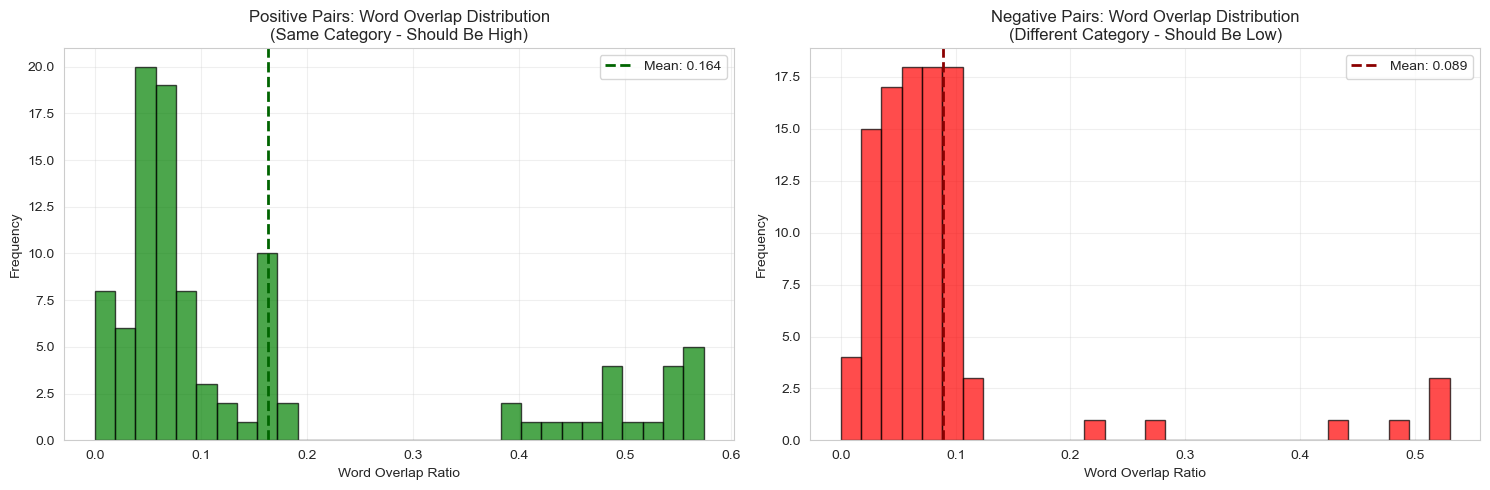

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Positive pairs
ax = axes[0]
ax.hist(pos_example_similarities, bins=30, color='green', alpha=0.7, edgecolor='black')
ax.set_xlabel('Word Overlap Ratio')
ax.set_ylabel('Frequency')
ax.set_title('Positive Pairs: Word Overlap Distribution\n(Same Category - Should Be High)')
ax.axvline(np.mean(pos_example_similarities), color='darkgreen', linestyle='--', linewidth=2, label=f'Mean: {np.mean(pos_example_similarities):.3f}')
ax.legend()
ax.grid(True, alpha=0.3)

# Negative pairs
ax = axes[1]
ax.hist(neg_example_similarities, bins=30, color='red', alpha=0.7, edgecolor='black')
ax.set_xlabel('Word Overlap Ratio')
ax.set_ylabel('Frequency')
ax.set_title('Negative Pairs: Word Overlap Distribution\n(Different Category - Should Be Low)')
ax.axvline(np.mean(neg_example_similarities), color='darkred', linestyle='--', linewidth=2, label=f'Mean: {np.mean(neg_example_similarities):.3f}')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Diagnose: Key Metrics

In [9]:
print("\n" + "="*80)
print("DIAGNOSIS: Why Fine-Tuned Models Underperform")
print("="*80)

# Check 1: Score separability
separability = pos_scores_baseline.mean() - neg_scores_baseline.mean()
print(f"\n1. BASELINE MODEL SEPARABILITY")
print(f"   Positive mean: {pos_scores_baseline.mean():.4f}")
print(f"   Negative mean: {neg_scores_baseline.mean():.4f}")
print(f"   Difference: {separability:.4f}")
if separability < 0.1:
    print(f"   ⚠️  WARNING: Poor separability! Scores barely different.")
else:
    print(f"   ✓ Good separability")

# Check 2: Overlap
print(f"\n2. SCORE DISTRIBUTION OVERLAP")
print(f"   % of positive scores < mean negative score: {(pos_scores_baseline < neg_scores_baseline.mean()).sum()/len(pos_scores_baseline)*100:.1f}%")
print(f"   % of negative scores > mean positive score: {(neg_scores_baseline > pos_scores_baseline.mean()).sum()/len(neg_scores_baseline)*100:.1f}%")
if overlap > 0.5:
    print(f"   ⚠️  WARNING: High overlap suggests noisy labels!")

# Check 3: Word overlap in pairs
print(f"\n3. SEMANTIC OVERLAP IN PAIRS")
print(f"   Positive pairs word overlap: {np.mean(pos_example_similarities):.4f}")
print(f"   Negative pairs word overlap: {np.mean(neg_example_similarities):.4f}")
print(f"   Difference: {np.mean(pos_example_similarities) - np.mean(neg_example_similarities):.4f}")
if abs(np.mean(pos_example_similarities) - np.mean(neg_example_similarities)) < 0.05:
    print(f"   ⚠️  WARNING: Positive and negative pairs are too similar!")
else:
    print(f"   ✓ Good semantic separation")

# Check 4: Category-based label validation
print(f"\n4. TEST SET COMPOSITION")
print(f"   Total pairs: {len(test_labels)}")
print(f"   Positive pairs: {sum(test_labels)} ({sum(test_labels)/len(test_labels)*100:.1f}%)")
print(f"   Negative pairs: {len(test_labels)-sum(test_labels)} ({(len(test_labels)-sum(test_labels))/len(test_labels)*100:.1f}%)")
print(f"   Expected ratio: 50-50 for balanced test set")

print(f"\n" + "="*80)
print("RECOMMENDATIONS:")
print("="*80)
if separability < 0.1:
    print("✗ Low baseline separability → Test set may have noisy/weak labels")
    print("  ACTION: Review 'positive' pair labels - same category ≠ semantically similar")
if overlap > 0.5:
    print("✗ High score overlap → Hard to distinguish positives from negatives")
    print("  ACTION: Use stricter pair generation (require min semantic similarity for positives)")
print("\nAll models (baseline + fine-tuned) struggle with this test set.")
print("The problem is likely in test pair generation, not model quality.")


DIAGNOSIS: Why Fine-Tuned Models Underperform

1. BASELINE MODEL SEPARABILITY
   Positive mean: 0.4878
   Negative mean: 0.5305
   Difference: -0.0427
   ⚠️  WARNING: Poor separability! Scores barely different.

2. SCORE DISTRIBUTION OVERLAP
   % of positive scores < mean negative score: 66.4%
   % of negative scores > mean positive score: 55.9%

3. SEMANTIC OVERLAP IN PAIRS
   Positive pairs word overlap: 0.1636
   Negative pairs word overlap: 0.0893
   Difference: 0.0743
   ✓ Good semantic separation

4. TEST SET COMPOSITION
   Total pairs: 1500
   Positive pairs: 500 (33.3%)
   Negative pairs: 1000 (66.7%)
   Expected ratio: 50-50 for balanced test set

RECOMMENDATIONS:
✗ Low baseline separability → Test set may have noisy/weak labels
  ACTION: Review 'positive' pair labels - same category ≠ semantically similar

All models (baseline + fine-tuned) struggle with this test set.
The problem is likely in test pair generation, not model quality.
